### Meeting a Sayed Athar's request, I'm using the Kernel altered by Khoi Nguyen to explain how the whole code works.
### If any part is not clear, please comment.  
### Please upvote if it was helpful.

In [1]:
import pandas as pd
import pyarrow.parquet as pq # Used to read the data
import matplotlib.pyplot as plt
import os 
import numpy as np
from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from tqdm import tqdm # Processing time measurement
from sklearn.model_selection import train_test_split 
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Used to use Kfold to train our model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting

import numpy.fft as fft
import seaborn as sns 

Using TensorFlow backend.


In [2]:
import pywt
from scipy import signal

In [3]:
# just load train data
df_train = pd.read_csv('../input/metadata_train.csv')
# set index, it makes the data access much faster
#df_train = df_train.set_index(['id_measurement', 'phase'])
df_train[df_train['target']==1]

,signal_id,id_measurement,phase,target
3,3,1,0,1
4,4,1,1,1
5,5,1,2,1
201,201,67,0,1
202,202,67,1,1
228,228,76,0,1
229,229,76,1,1
230,230,76,2,1
270,270,90,0,1
271,271,90,1,1


In [4]:
badones=df_train[df_train['target']==1]['id_measurement'].unique()
goodones=df_train[df_train['target']==0]['id_measurement'].unique()

In [5]:
t=np.linspace(0,800000,800000)

def ffttransform(v):
    start,end=v*3,v*3+3
    praq_train = pq.read_pandas('../input/train.parquet', columns=[str(i) for i in range(start, end)]).to_pandas()
    
    color=[]
    m=0
    cycle = [str(start+1),str(start+2),str(start)]
    for i in range(start, end):
        fz = fft.fft(praq_train[str(i)])/800000
        phi = np.angle(fz[1],deg=True)+90
        amp = 2*np.abs(fz[1])
        df_train.at[i, 'angle'] = phi
        df_train.at[i,'amplitude'] = amp
        
        praq_train[str(i)+'fft'] = np.abs(fz)
        praq_train[str(i)+'fity'] = amp*np.sin(2*np.pi*t+phi/180*np.pi)
        praq_train[str(i)+'res'] = praq_train[str(i)] - praq_train[str(i)+'fity']
        
        df_train.at[i,'resstd'] = praq_train[str(i)+'res'].std()
        color += [(m==0,m==1,m==2,1-0.5*df_train.loc[i]['target'])]
        
        praq_train[str(i)+"-"+cycle[m]] = praq_train[str(i)] - praq_train[cycle[m]]
        m+=1
    color += [(1,1,1,1)]*3
    praq_train[[str(start)+"-"+cycle[0],str(start+1)+"-"+cycle[1],str(start+2)+"-"+cycle[2]]][295550:295600].plot(color=color)
    praq_train[[str(start),str(start+1),str(start+2),str(start)+'fity',str(start+1)+'fity',str(start+2)+'fity']][295550:295600].plot(color=color)
    praq_train[[str(start)+'res',str(start+1)+'res',str(start+2)+'res']].plot(color=color)
    
    praq_train[[str(start)+'fft',str(start+1)+'fft',str(start+2)+'fft']][0:400000].plot(color=color)
    praq_train['wavesum']=praq_train[[str(start),str(start+1),str(start+2)]].sum(axis=1)
    praq_train[['wavesum']].plot()
    praq_train['squaresum']=np.power(praq_train[[str(start),str(start+1),str(start+2)]],2,dtype = int).sum(axis=1)
    praq_train[['squaresum']].plot()
    df_train.at[[start,start+1,start+2], 'sumstd']=praq_train['wavesum'].std()
    
#    praq_train['fftmean']=praq_train[[str(start)+'fft',str(start+1)+'fft',str(start+2)+'fft']].mean(axis=1)

#     for i in range(start, end):
#         praq_train[str(i)+'df_fft']=praq_train[str(i)+'fft']-praq_train['fftmean']
#     praq_train[[str(start)+'df_fft',str(start+1)+'df_fft',str(start+2)+'df_fft']][0:4000].plot(color=color

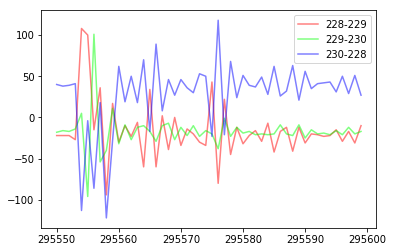

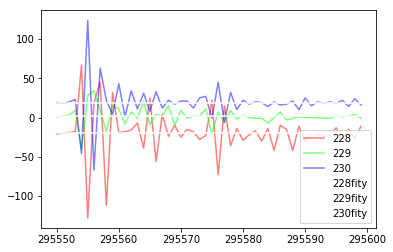

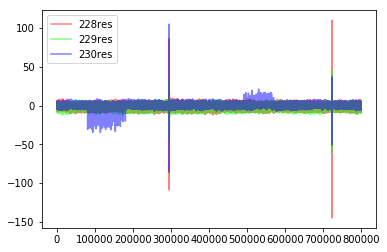

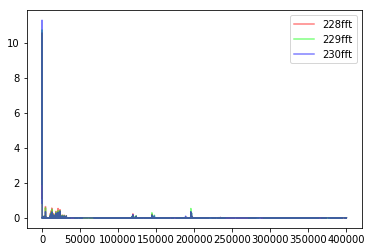

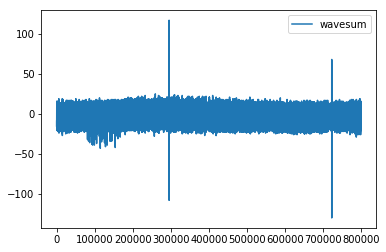

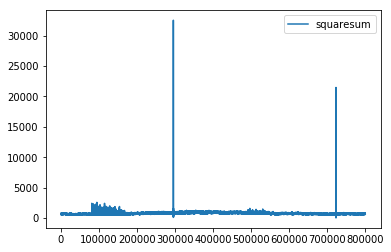

In [6]:
for v in badones[2:3]:
    ffttransform(v)

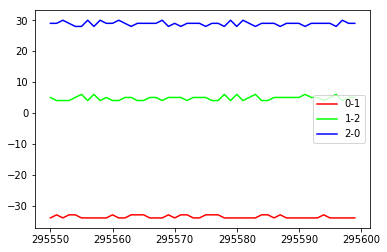

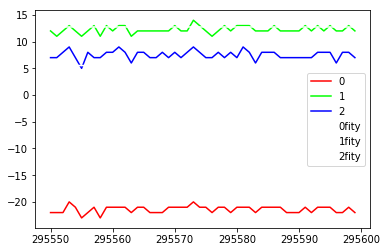

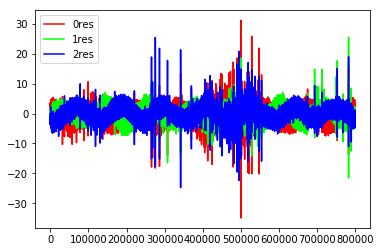

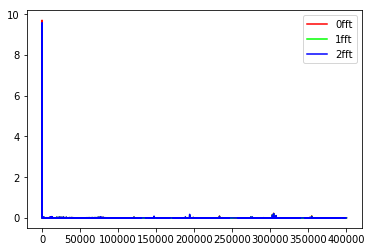

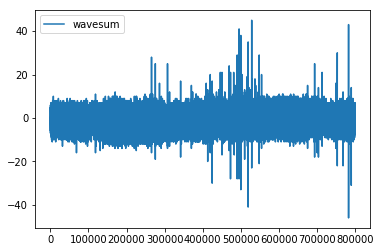

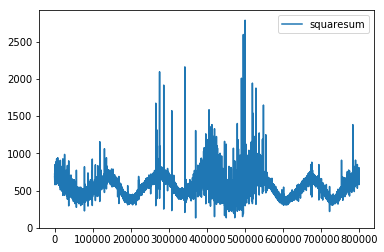

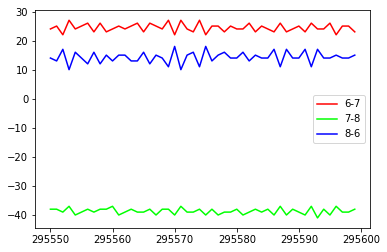

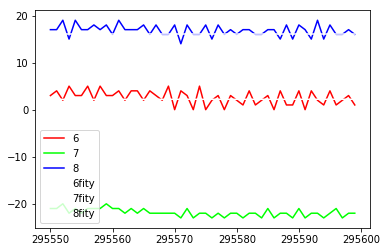

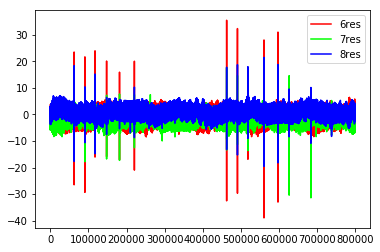

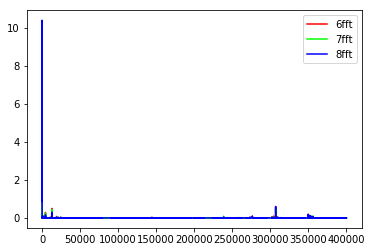

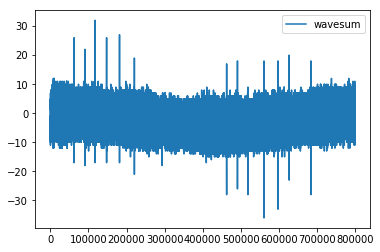

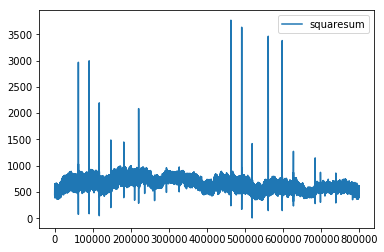

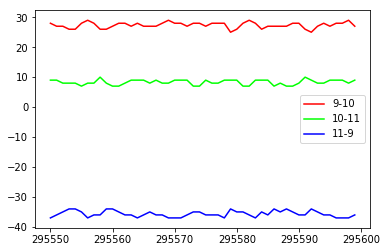

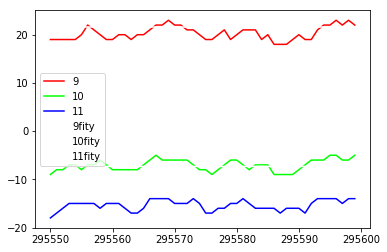

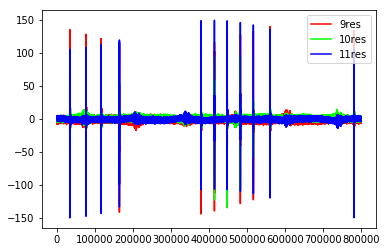

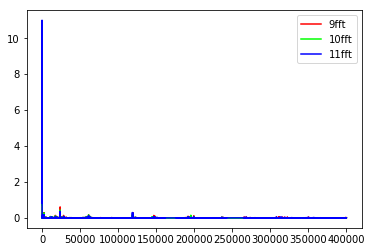

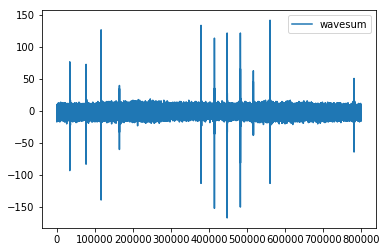

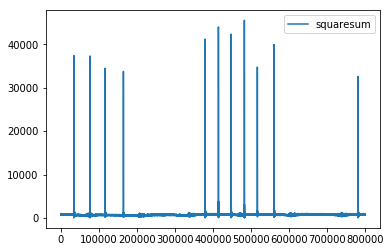

In [7]:
for v in goodones[0:3]:
    ffttransform(v)

In [8]:
praq[[str(i) for i in range(3, 6)]][:10]

NameError: name 'praq' is not defined

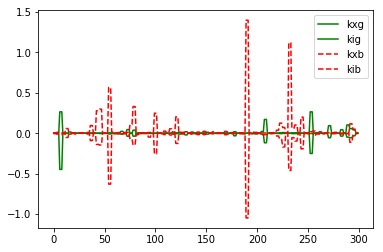

In [9]:
def plot_wav(ID,nl,w):
    cwt=[[],[],[]]
    k_max=[]
    k_min=[]
    #plt.figure()
    for m in range(3):
        t = pq.read_pandas('../input/train.parquet', columns=[str(ID*3+m)]).to_pandas()[str(ID*3+m)]/128
        #plt.plot(t)
        cwt[m] = pywt.wavedec(t, w, level=nl)
    
        for i in range(nl,nl+1):
            k=cwt[0][i][:int(len(cwt[0][i])/2)]*cwt[0][i][int(len(cwt[0][i])/2):]
            #plt.plot(k)   
            k_max.append(max(k))
            k_min.append(min(k))
    #plt.tight_layout()
    #plt.show()
    return k_max,k_min

w = pywt.Wavelet('coif5')
nl=5   
k_max_good,k_min_good,k_max_bad,k_min_bad = [],[],[],[]
for ID in goodones[:100]:
    _a,_b=plot_wav(ID,nl,w)
    k_max_good+=_a
    k_min_good+=_b
    
for ID in badones[:100]:
    _a,_b=plot_wav(ID,nl,w)
    k_max_bad+=_a
    k_min_bad+=_b

plt.figure()
plt.plot(k_max_good,color='g', linestyle='-',label='kxg')
plt.plot(k_min_good,color='g', linestyle='-',label='kig')
plt.plot(k_max_bad,color='r', linestyle='--',label='kxb')
plt.plot(k_min_bad,color='r', linestyle='--',label='kib')
plt.legend(loc='best')

In [10]:
print(np.mean([k_max_good,k_min_good,k_max_bad,k_min_bad],axis=1))

[ 0.01475435 -0.01451612  0.06000036 -0.04504346]


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


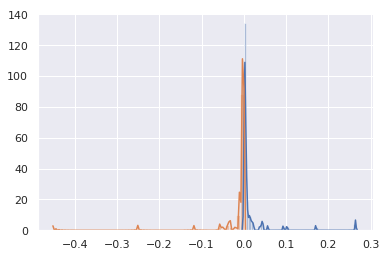

In [11]:
sns.set(color_codes=True)
sns.distplot(k_max_good)
sns.distplot(k_min_good)


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


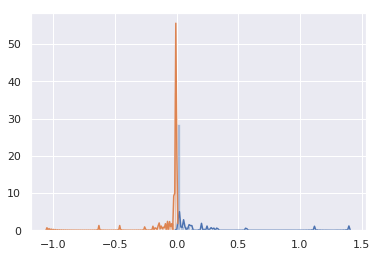

In [12]:
sns.distplot(k_max_bad)
sns.distplot(k_min_bad)



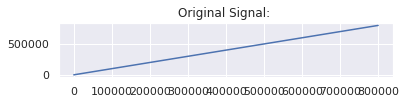

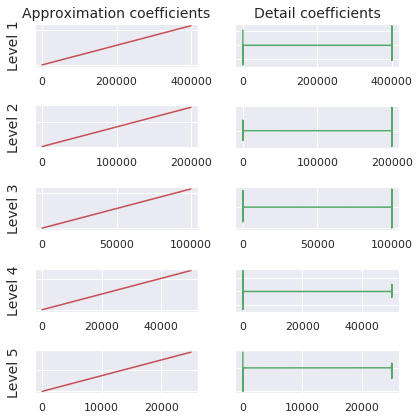

In [13]:
fig, ax = plt.subplots(figsize=(6,1))
ax.set_title("Original Signal: ")
ax.plot(t)
plt.show()
    
data = t
waveletname = 'db10'
 
fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))
for ii in range(5):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    axarr[ii, 0].plot(data, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

(10, 5400)


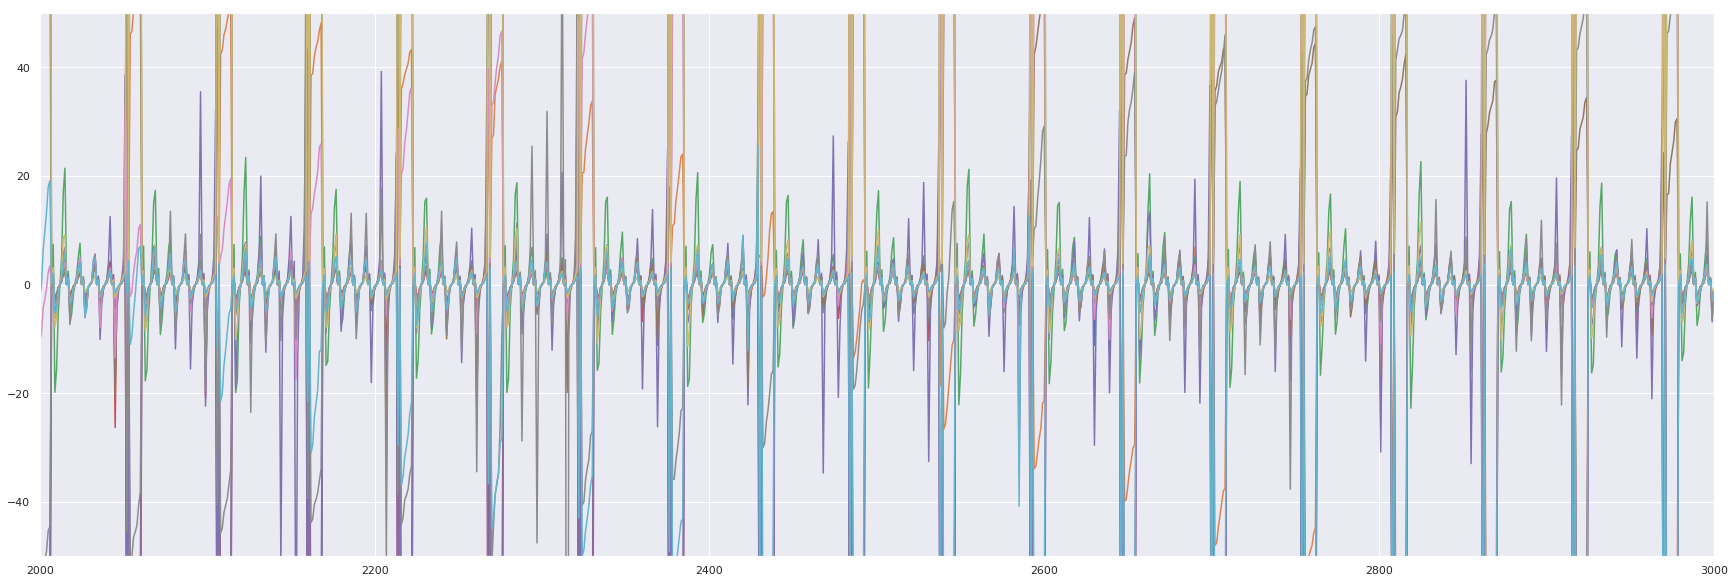

In [14]:
new_ts = []
for ID in badones[:10]:
    for j in range(ID*3,ID*3+3):
        ts = pq.read_pandas('../input/train.parquet', columns=[str(j)]).to_pandas()[str(j)]
        nj=[]
        for i in range(0, 800000, 8000):
            ts_range = ts[i:i + 8000]
            cwt = pywt.wavedec(ts_range, w, level=nl)
            for j in range(nl+1):
                mean = cwt[j].mean()
                std = cwt[j].std()
                percentil = np.percentile(cwt[j], [0, 1, 25, 50, 75, 99, 100]) 
                nj += [mean,std]
                nj += list(percentil)
    new_ts += [nj]
print(np.asarray(new_ts).shape)

plt.figure(figsize=(30,10))
for feature in new_ts:
    plt.axis([2000,3000,-50,50])
    plt.plot(feature)
plt.show()

(10, 5400)


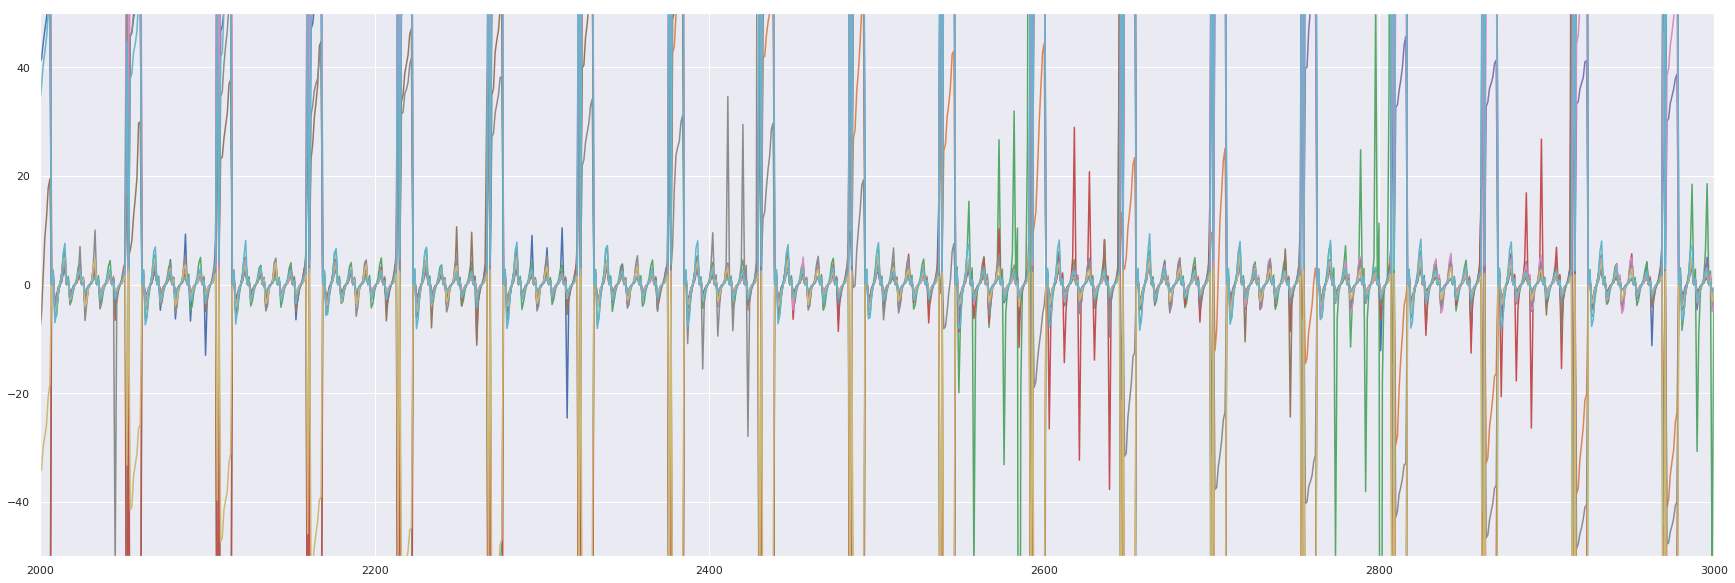

In [15]:
new_ts = []
for ID in goodones[:10]:
    for j in range(ID*3,ID*3+3):
        ts = pq.read_pandas('../input/train.parquet', columns=[str(j)]).to_pandas()[str(j)]
        nj=[]
        for i in range(0, 800000, 8000):
            ts_range = ts[i:i + 8000]
            cwt = pywt.wavedec(ts_range, w, level=nl)
            for j in range(nl+1):
                mean = cwt[j].mean()
                std = cwt[j].std()
                percentil = np.percentile(cwt[j], [0, 1, 25, 50, 75, 99, 100]) 
                nj += [mean,std]
                nj += list(percentil)
    new_ts += [nj]
print(np.asarray(new_ts).shape)

plt.figure(figsize=(30,10))
for feature in new_ts:
    plt.axis([2000,3000,-50,50])
    plt.plot(feature)
plt.show()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


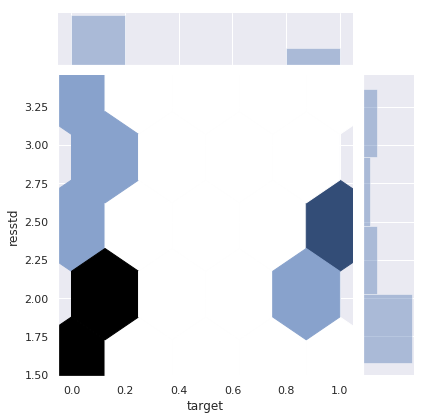

In [16]:
sns.jointplot(x=df_train["target"],y=df_train['resstd'],kind='hex')

In [17]:
def map_wav(ID):
    #plt.figure()
    widths = np.logspace(2,5.5,50)
    print(widths)
    for m in range(3):
        t = pq.read_pandas('../input/train.parquet', columns=[str(ID*3+m)]).to_pandas()[str(ID*3+m)]
        
        
        cwtmatr = signal.cwt(t,signal.ricker, widths)
        plt.imshow(cwtmatr, 
                   extent=[0,-1 , 1, 50],
                   cmap='PRGn',
                   aspect='auto',
                   vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max()
                  )
        plt.show()

[1.00000000e+02 1.17876863e+02 1.38949549e+02 1.63789371e+02
 1.93069773e+02 2.27584593e+02 2.68269580e+02 3.16227766e+02
 3.72759372e+02 4.39397056e+02 5.17947468e+02 6.10540230e+02
 7.19685673e+02 8.48342898e+02 1.00000000e+03 1.17876863e+03
 1.38949549e+03 1.63789371e+03 1.93069773e+03 2.27584593e+03
 2.68269580e+03 3.16227766e+03 3.72759372e+03 4.39397056e+03
 5.17947468e+03 6.10540230e+03 7.19685673e+03 8.48342898e+03
 1.00000000e+04 1.17876863e+04 1.38949549e+04 1.63789371e+04
 1.93069773e+04 2.27584593e+04 2.68269580e+04 3.16227766e+04
 3.72759372e+04 4.39397056e+04 5.17947468e+04 6.10540230e+04
 7.19685673e+04 8.48342898e+04 1.00000000e+05 1.17876863e+05
 1.38949549e+05 1.63789371e+05 1.93069773e+05 2.27584593e+05
 2.68269580e+05 3.16227766e+05]


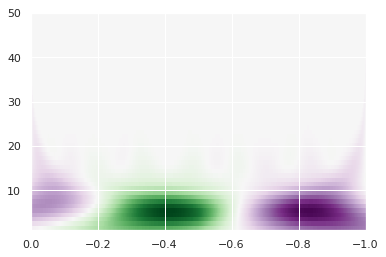

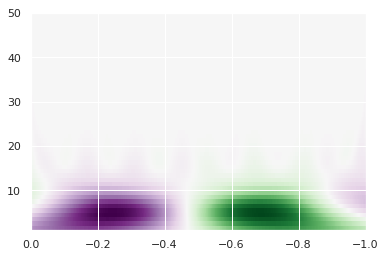

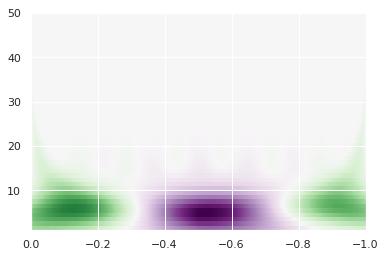

In [18]:
map_wav(1)

100


/opt/conda/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


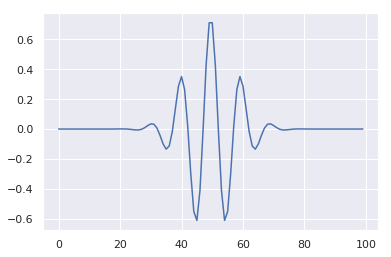

In [19]:
points = 100
a = 2
vec2 = signal.morlet(100, w=5.0, s=1.0, complete=False)
print(len(vec2))

plt.plot(vec2)
plt.show()